# (Stroke_Prediction) RANDOM FOREST DIAGNOSTIC
https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
W tej części przeprowadzę klasyfikację za pomocą modeli
1. Model regresji logistycznej
2. Random Forest Classifier
3. Naive Bayes Classifier
4. Support Vector Machine Classifier

Z powodu zastosowania systemów optymalizacji sklearn.pipeline i GridSearchCV niektóre modele bardzo długo się liczą. 
Dlatego zostały one zablokowane.

In [1]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Pomiar czasu wykonania tego zadania')

Fri Mar 20 21:32:58 2020
Pomiar czasu wykonania tego zadania


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction_NUM.csv' , nrows = 29000)
# , nrows = 290
headers = ['ID', 'Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married',
       'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI', 'Smoking_Status',
       'Stroke', 'Age_years', 'Age_years_10', 'Gender_C', 'Ever_Married_C',
       'Type_Of_Work_C', 'Residence_C', 'Smoking_Status_C', 'Age_years_10_C']
#grupa_testowa= pd.read_csv('c:/1/Stroke_Prediction_NUM.csv', skiprows = 29000, header=None, names=headers)
# , nrows = 1000
print(df.shape)
#print(grupa_testowa.shape)
df.head(5)

(29000, 20)


,Unnamed: 0,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
0,0,30650,Male,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,58.093151,"(53.126, 59.076]",1,1,2,1,1,5
1,1,57008,Female,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,70.076712,"(65.121, 74.11]",0,1,2,0,0,7
2,2,53725,Female,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0,52.041096,"(48.082, 53.126]",0,1,2,1,0,4
3,3,41553,Female,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0,75.104110,"(74.11, 82.137]",0,1,3,0,1,8
4,4,16167,Female,0,0,Yes,Private,Rural,77.67,32.3,smokes,0,32.024658,"(29.055, 36.058]",0,1,2,0,2,1


### <span style="color:blue">Wprowadzam zmienną syntetyczną</span>

Wprowadzanie zmiennych syntetycznych może poprawić zdolności klasyfikacyjne modelu.
Tę zmienną zrobiłem, aby pokazać, że stosuję tę technikę.

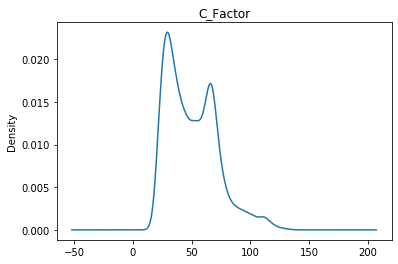

In [3]:
df['C_Factor'] = (df['BMI']+(5*(df['Age_years_10_C']*df['Smoking_Status_C'])))
fig, ax = plt.subplots()
df['C_Factor'].plot.kde(ax=ax, legend=False, title='C_Factor')

### <span style="color:blue">Analiza poziomu zbilansowania zmiennej wynikowej</span>

In [4]:
del df['Unnamed: 0']
df.Stroke.value_counts(dropna = False, normalize=True)

0    0.981172
1    0.018828
Name: Stroke, dtype: float64

Zbiór zmiennych wynikowych wymaga zbilansowania. Do bilansowania zmiennych wynikowych stosuję trzy metody:
- class_weight (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistyczne-czesc-4-zastosowanie-class_weight/)
-  oversampling (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistycznej-czesc-2-oversampling/)
- zmiana progu (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistycznej-czesc-3-zmiana-progu-w-modelu-regresji-logistycznej/)

Wszystkie trzy metody powinny dać podobne efekty przy klasyfikacji. Dzisiaj do zbilansowania zbioru zastosuję metodę oversampling. Oversampling odbywa się na zbiorze treningowym, więc najpierw trzeba podzielić zbiór na treningowy i testowy.

### <span style="color:blue">2. Podział na zbiór testowy i wynikowy</span>

In [5]:
df2 = df[['C_Factor','Hypertension','Heart_Disease','Avg_Glucose','BMI','Stroke','Age_years','Gender_C','Ever_Married_C','Type_Of_Work_C','Residence_C','Smoking_Status_C','Age_years_10_C']]

In [6]:
y = df2['Stroke']
X = df2.drop('Stroke', axis=1)

In [7]:
from sklearn.model_selection import train_test_split 
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.33, stratify = y, random_state = 148)

print ('Zbiór X treningowy: ',Xtrain.shape)
print ('Zbiór X testowy:    ', Xtest.shape)
print ('Zbiór y treningowy: ', ytrain.shape)
print ('Zbiór y testowy:    ', ytest.shape)

Zbiór X treningowy:  (19430, 12)
Zbiór X testowy:     (9570, 12)
Zbiór y treningowy:  (19430,)
Zbiór y testowy:     (9570,)


In [8]:
print("ytrain = 0: ", sum(ytrain == 0))
print("ytrain = 1: ", sum(ytrain == 1))

ytrain = 0:  19064
ytrain = 1:  366


In [9]:
Proporcja = sum(ytrain == 0) / sum(ytrain == 1) 
Proporcja = np.round(Proporcja, decimals=0)
Proporcja = Proporcja.astype(int)
print('Ilość 0 Stroke na 1 Stroke: ', Proporcja)

Ilość 0 Stroke na 1 Stroke:  52


In [10]:
ytrain_OVSA = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
ytrain_OVSA.count()

19032

Powiękrzyliśmy ilość zmiennych wynikowych 1. Teraz mamy tę samą liczbę wierszy zmiennych wynikowych i zmiennych niezależnych. Teraz wprowadzamy nowe, dodatkowe zmienne 1 do zbioru treningowego.

In [11]:
Xtrain_OVSA = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
ytrain_OVSA.count()

19032

In [12]:
ytrain_OVSA = pd.concat([ytrain, ytrain_OVSA], axis = 0).reset_index(drop = True)
Xtrain_OVSA = pd.concat([Xtrain, Xtrain_OVSA], axis = 0).reset_index(drop = True)

print("ilość elementów w zbiorze Xtrain:     ", Xtrain.BMI.count())
print("ilość elementów w zbiorze Xtrain_OVSA: ", Xtrain_OVSA.BMI.count())
print("ilość elementów w zbiorze ytrain:     ", ytrain.count())
print("ilość elementów w zbiorze ytrain_OVSA: ", ytrain_OVSA.count())

ilość elementów w zbiorze Xtrain:      19430
ilość elementów w zbiorze Xtrain_OVSA:  38462
ilość elementów w zbiorze ytrain:      19430
ilość elementów w zbiorze ytrain_OVSA:  38462


Poziom zbilansowania zbioru wynikowego:

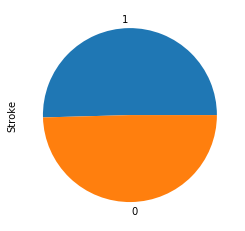

In [13]:
ytrain_OVSA.value_counts(dropna = False, normalize=True).plot(kind='pie')

### <span style="color:blue">Model regresji logistycznej</span>

Ocena modelu:

### <span style="color:blue">4. Random Forest Classifier - with pipeline GridSearchCV</span>

Hiperparametry:
„n_estimators” - liczba drzew. Większa liczba drzew zwiększa wydajność i sprawia, że prognozy są bardziej stabilne, ale także spowalnia obliczenia.

„N_jobs” - ile procesorów jest dozwolone do użycia. Jeśli ma wartość 1, może używać tylko jednego procesora. Wartość „-1” oznacza, że nie ma limitu.

„Random_state” umożliwia replikację danych wyjściowych modelu. Model zawsze będzie dawał takie same wyniki, gdy ma określoną wartość random_state i jeśli otrzymał te same hiperparametry i te same dane treningowe.

„min_sample_leaf” minimalną liczbę listków wymaganych do podziału wewnętrznego węzła.

## <div class="alert-danger"> Uwaga! Czas obliczeń poniższego modelu trwa 25 minut dla próbki 29 tys.
Model został zamrożony dla zaoszczędzenia czasu.</div>   

### <span style="color:blue">Random Forest Classifier - simple version</span>
Hiperparametry dobrane ręcznie

## https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

In [14]:
from sklearn.ensemble import RandomForestClassifier

forestVC = RandomForestClassifier (random_state = 1, 
                                  n_estimators = 350, 
                                  max_depth = 2, 
                                  min_samples_split = 2, min_samples_leaf = 3) 
RFC_S = forestVC.fit(Xtrain_OVSA, ytrain_OVSA)
y_pred_RFC = RFC_S.predict(Xtest)

Ocena modelu:

Recall Training data:      0.8579
Precision Training data:   0.718
----------------------------------------------------------------------
Recall Test data:          0.8389
Precision Test data:       0.0434
----------------------------------------------------------------------
Confusion Matrix Test data
[[6061 3329]
 [  29  151]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.65      0.78      9390
           1       0.04      0.84      0.08       180

    accuracy                           0.65      9570
   macro avg       0.52      0.74      0.43      9570
weighted avg       0.98      0.65      0.77      9570



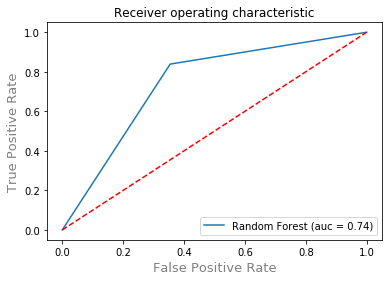

In [15]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report


print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, RFC_S.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, RFC_S.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, RFC_S.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, RFC_S.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, RFC_S.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, RFC_S.predict(Xtest)))
y_pred_proba = RFC_S.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_RFC)
auc = metrics.roc_auc_score(ytest, y_pred_RFC)
plt.plot(fpr, tpr, label='Random Forest (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

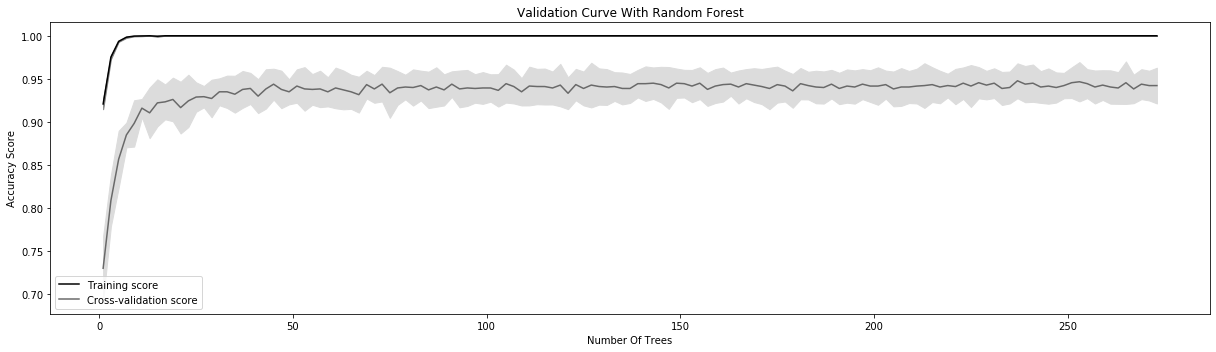

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

## źródło: https://www.dezyre.com/recipes/plot-validation-curve-in-python

## Przerabiam data frame na macierz

import numpy as np
X = np.asarray(Xtrain_OVSA)
Y = np.asarray(ytrain_OVSA)

digits = load_digits()
# Create feature matrix and target vector
X, y = digits.data, digits.target
# Plot Validation Curve
    
# Create range of values for parameter
param_range = np.arange(1, 275, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(),
                               X, y, param_name="n_estimators", param_range=param_range,
                               cv=4, scoring="accuracy", n_jobs=-1)

  # Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(17,5))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

    # Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

    # Create plot    
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()




In [18]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

ValueError: Number of features of the model must match the input. Model n_features is 64 and input n_features is 2 

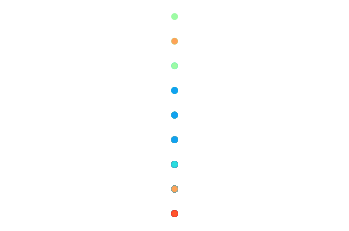

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

### <span style="color:blue">Naive Bayes Classifier</span>

Ocena modelu:

### <span style="color:blue">Support Vector Machine Classifier</span>

## <div class="alert-danger"> Uwaga! Czas obliczeń poniższego modelu trwa ponad 35 minut dla próbki 29 tys. 
Model został zamrożony dla zaoszczędzenia czasu.
</div>   

### <span style="color:blue">Support Vector Machine Classifier - simple version</span>

### Podsumowanie modeli klasyfikacji
- Modele osiagnęły wynik ROC od 73 do 89.
- Modele nie są przeuczone, ponieważ wartość Recall dla zbiorów testowych i treningowych miały podobne wartości.
- Istnieje bardzo duża różnica w mierniku 'precision' pomiedzy zmiennymi testowymi i treningowymi.
W modelach w zestawach testowych istnieje bardzo niski poziom 'precision'. Wynika to z ogromnego niezbilansowania zbiorów wynikowych. Tylko jeden pacjent na 52 doznaje udaru.
'Recall' jest miarą kompletności wyników.
'Precision' jest miarą 'zaśmiecenia wyników'.

<div class="alert-info">
<span style="color:darkblue">RECALL </span>definiuje się jako liczbę zjawisk: 'stroke' pobranych przez wyszukiwanie podzieloną przez całkowitą liczbę istniejących zjawisk: 'stroke'.

<span style="color:darkblue">PRECISION </span>definiuje się jako liczbę zjawisk: 'stroke' pobranych przez wyszukiwanie podzieloną przez całkowitą liczbę pacjentów pobranych przez to wyszukiwanie.
</div>

Aby udowodnić to, że powodem niskiego poziomu 'precision' jest niezbilansowanie testowego zbioru wynikowego przeprowadziłem krótkie doświadczenie. Wykonałem oversampling w zbiorze testowym, a następnie wstawiłem zbilansowany zbiór testowy do najprostszego z modeli: Naive Bayes Classifier


### Oversampling dla zbioru testowego

### Podstawienie Xtrain_OVSA do modelu Naive Bayes Classifier

Jak widać, model posiada podobne właściwości dla danych testowych i treningowych.
Eksperyment potwiedził, że powodem niskiego stanu 'precision' było wysokie niezbilansowanie zbioru testowego.

# <span style="color:darkblue">Wykorzystanie modeli w praktyce</span>

<div class="alert-warning">Przyjmijmy założenie, że do lekarza zgłasza się 62 pacjentów. Są to te osoby (rekordy), które nie brały udziału w ćwiczeniach i były od początku odseparowane. Osoby te chcą dowiedzieć się, czy są zagrożone udarem.</div>

Wprowadzam zmienną syntetyczną.